In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
#import util
# pd.set_option('display.float_format', lambda x: '%.3f' % x)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
from time import time
import os

from scipy.optimize import fmin_powell
from scipy import integrate

import theano as thno
import theano.tensor as T


In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

class AdditionalAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, include_additional_attr = True): # no *args or **kargs
        self.include_additional_attr = include_additional_attr
        self.guille_feature_names = ['H', 'dest_A_1', 'dest_A_2', 'dest_A_3', 'dest_A_4', 'dest_A_5',
                                     'dest_A_6', 'dest_I', 'dest_dTR', 'dest_hK', 'dest_hM', 'dest_mR', 
                                     'src_A_1', 'src_A_2', 'src_A_3', 'src_A_4', 'src_A_5', 'src_A_6', 
                                     'src_I', 'src_dTR', 'src_hK', 'src_hM','src_mR']
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        if self.include_additional_attr:
            return X # might need to check if this returns pandas or a numpy, i need a numpy
        else:
            return X[self.guille_feature_names]

In [3]:
from joblib import dump

def save_models(saveas, rnd_estimator, lr_estimator):
    save_to = '../models/'
    saveas = os.path.join(save_to, saveas)
    if os.path.exists(saveas):
        raise FileExistsError(f'The path "{os.path.abspath(saveas)}" already exists, ' 
                              'please choose a new name.')
    else:
        rfc_dir = os.path.join(saveas, 'rfc')
        bayes_dir = os.path.join(saveas, 'bayes/')
        
        os.makedirs(rfc_dir)
        os.mkdir(bayes_dir)
    
    # save random forest estimator
    dump(rnd_estimator, os.path.join(rfc_dir, 'model.rnd'))
    
    # save bayesian logistic regression model
    lr_estimator.save(bayes_dir)

Set Project Parameters

In [4]:
include_additional_attr = True
dataset_filepath = '/Users/aaarise/Desktop/info-diffusion-master/data/raw/processed/dataset.h5'
dataset_key = 'VHSFzdEjWnYlivX'

if not os.path.exists(dataset_filepath):
    raise FileNotFoundError(f'{os.path.abspath(dataset_filepath)} does not exist.')

# Explore Dataset

In [5]:
# dataset = pd.read_csv(dataset_filepath)
dataset = pd.read_hdf(dataset_filepath, key=dataset_key)

# Remove user_ids from dataframe
dataset = dataset.drop(['src_user_id', 'dest_user_id'], axis=1)
dataset.head()

,H,dest_A_1,dest_A_2,dest_A_3,dest_A_4,dest_A_5,dest_A_6,dest_I,dest_avg_negative_sentiment_of_tweets,dest_avg_number_followers,...,src_ratio_of_retweets_to_tweets,src_ratio_of_tweet_per_time_period_1,src_ratio_of_tweet_per_time_period_2,src_ratio_of_tweet_per_time_period_3,src_ratio_of_tweet_per_time_period_4,src_ratio_of_tweets_that_got_retweeted_per_time_period_1,src_ratio_of_tweets_that_got_retweeted_per_time_period_2,src_ratio_of_tweets_that_got_retweeted_per_time_period_3,src_ratio_of_tweets_that_got_retweeted_per_time_period_4,y
0,0.000000,0.000000,0.400000,0.400000,0.200000,0.000000,0.000000,0.006853,1.0,0.028289,...,0.406832,0.274845,0.013975,0.387267,0.323913,0.015528,0.001553,0.034783,0.025776,0
1,0.000000,0.385459,0.133358,0.018634,0.036171,0.173913,0.252466,1.000000,1.0,0.449788,...,0.406832,0.274845,0.013975,0.387267,0.323913,0.015528,0.001553,0.034783,0.025776,0
2,0.008322,0.251245,0.033204,0.059214,0.202546,0.246265,0.207526,1.000000,1.0,0.175389,...,0.406832,0.274845,0.013975,0.387267,0.323913,0.015528,0.001553,0.034783,0.025776,0
3,0.001314,0.262357,0.029468,0.020913,0.188847,0.198035,0.300380,1.000000,1.0,1.000000,...,0.406832,0.274845,0.013975,0.387267,0.323913,0.015528,0.001553,0.034783,0.025776,0
4,0.005362,0.681957,0.116208,0.000000,0.015291,0.131498,0.055046,0.448191,1.0,0.074965,...,0.406832,0.274845,0.013975,0.387267,0.323913,0.015528,0.001553,0.034783,0.025776,0


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27555 entries, 0 to 27554
Data columns (total 84 columns):
H                                                            27555 non-null float64
dest_A_1                                                     27555 non-null float64
dest_A_2                                                     27555 non-null float64
dest_A_3                                                     27555 non-null float64
dest_A_4                                                     27555 non-null float64
dest_A_5                                                     27555 non-null float64
dest_A_6                                                     27555 non-null float64
dest_I                                                       27555 non-null float64
dest_avg_negative_sentiment_of_tweets                        27555 non-null float64
dest_avg_number_followers                                    27555 non-null float64
dest_avg_number_friends                            

In [7]:
dataset.describe()

,H,dest_A_1,dest_A_2,dest_A_3,dest_A_4,dest_A_5,dest_A_6,dest_I,dest_avg_negative_sentiment_of_tweets,dest_avg_number_followers,...,src_ratio_of_retweets_to_tweets,src_ratio_of_tweet_per_time_period_1,src_ratio_of_tweet_per_time_period_2,src_ratio_of_tweet_per_time_period_3,src_ratio_of_tweet_per_time_period_4,src_ratio_of_tweets_that_got_retweeted_per_time_period_1,src_ratio_of_tweets_that_got_retweeted_per_time_period_2,src_ratio_of_tweets_that_got_retweeted_per_time_period_3,src_ratio_of_tweets_that_got_retweeted_per_time_period_4,y
count,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,27555.0,27555.000000,...,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000,27555.000000
mean,0.007352,0.235696,0.088398,0.026114,0.180951,0.253889,0.214951,0.647947,1.0,0.498483,...,0.529141,0.301540,0.058045,0.304709,0.335706,0.128372,0.027521,0.135878,0.139539,0.008746
std,0.052017,0.120632,0.095023,0.050082,0.102471,0.106671,0.069182,0.393327,0.0,0.387708,...,0.258748,0.136608,0.087527,0.130035,0.100345,0.110684,0.053275,0.116774,0.104045,0.093113
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002741,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.173503,0.021874,0.003085,0.118475,0.200821,0.174806,0.226151,1.0,0.134371,...,0.333333,0.229355,0.013289,0.226198,0.284468,0.040470,0.003111,0.053042,0.057259,0.000000
50%,0.000000,0.221613,0.066421,0.010597,0.174701,0.241379,0.215332,1.000000,1.0,0.413013,...,0.511476,0.306550,0.031524,0.299220,0.336963,0.108076,0.011628,0.122427,0.116214,0.000000
75%,0.005917,0.311475,0.125000,0.026471,0.233546,0.286342,0.257143,1.000000,1.0,1.000000,...,0.756944,0.389474,0.065574,0.373051,0.388704,0.185862,0.032258,0.186205,0.209260,0.000000
max,1.000000,0.681957,0.666667,0.500000,0.666667,1.000000,0.500000,1.000000,1.0,1.000000,...,1.000000,0.798165,0.833333,1.000000,0.785714,0.666667,0.533333,1.000000,0.500000,1.000000


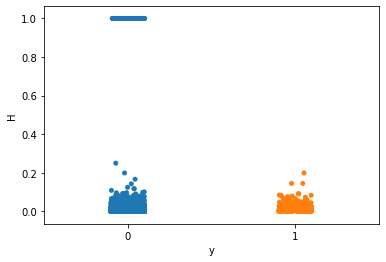

In [8]:
sns.stripplot(x="y", y="H", data=dataset, jitter=True)

In [9]:
X = dataset.drop("y", axis=1) # drop labels for training set
y = dataset["y"].copy()

feature_names = X.columns.values

y.value_counts()

0    27314
1      241
Name: y, dtype: int64

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

pipeline = Pipeline([
    ('attribs_adder', AdditionalAttributes(include_additional_attr = include_additional_attr)),
    ('imputer', SimpleImputer(strategy="mean")),
])

# ('std_scaler', StandardScaler()),

X = pipeline.fit_transform(X)

In [11]:
# resample using SMOTE balance
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X, y)

In [12]:
# column values based on whether additional attributes is true or false
# include_additional_attr = pipeline.named_steps['attribs_adder'].include_additional_attr
guille_feature_names = pipeline.named_steps['attribs_adder'].guille_feature_names

if not include_additional_attr:
    feature_names = guille_feature_names

In [13]:
X_resampled = pd.DataFrame(X_resampled, columns=feature_names)
y_resampled = pd.Series(y_resampled)

In [14]:
y_resampled.value_counts()

1    27314
0    27314
dtype: int64

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [16]:
print ('x_train shape: ', X_train.shape)
print ('y_train shape: ', y_train.shape)
print ('x_test shape: ', X_test.shape)
print ('y_test shape: ', y_test.shape)

x_train shape:  (43702, 83)
y_train shape:  (43702,)
x_test shape:  (10926, 83)
y_test shape:  (10926,)


## Exploring the data

In [17]:
#g = seaborn.pairplot(data)

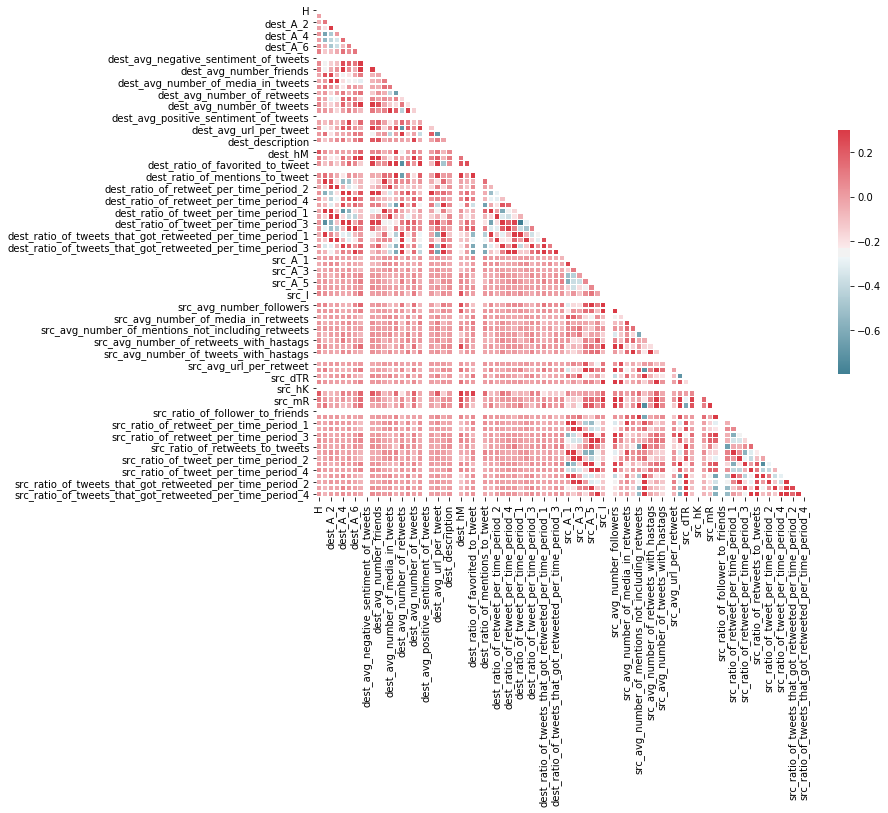

In [18]:
# Compute the correlation matrix
corr = X_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)



## Build Bayesian Logistics Regression Model

In [19]:
X = X_resampled[features]
y = y_resampled.copy()

NameError: name 'features' is not defined

In [ ]:
y.value_counts()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print ('x_train shape: ', X_train.shape)
print ('y_train shape: ', y_train.shape)
print ('x_test shape: ', X_test.shape)
print ('y_test shape: ', y_test.shape)

In [ ]:
#g = seaborn.pairplot(data)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
from pymc3_models.models.LogisticRegression import LogisticRegression

LR = LogisticRegression()
LR.fit(X_train, y_train, inference_type='nuts', inference_args={'draws': 2000})

In [ ]:
#az.plot_trace(LR.trace)

In [ ]:
LR.summary

In [ ]:
y_pred = LR.predict(X_test)

In [ ]:
y_score = LR.predict_proba(X_test)

### Performance

In [ ]:
LR.score(X_test, y_test)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['1', '0']);

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_score)

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score
precision_score(y_test, y_pred)

In [ ]:
recall_score(y_test, y_pred)

In [ ]:
f1_score(y_test, y_pred)

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure as fig
fig(num=None, figsize=(6, 4), dpi=300, facecolor='w', edgecolor='k')
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.title('ROC curve using top-15 features', fontweight='bold')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_score(y_test, y_score))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
save_models(saveas='big-network-full-attr-kansas-bayes', rnd_estimator=clf, lr_estimator=LR)